In [56]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [57]:
common_config.figure_journal_basic()

In [58]:
import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [59]:
adata = sc.read_h5ad("data/zhang_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 150504 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'Cluster_colors', 'Efficacy_colors', 'Group_colors', 'Major celltype_colors', 'Treatment_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [60]:
adata.obs["Group"].value_counts()

Group
Pre-treatment     89219
Post-treatment    61285
Name: count, dtype: int64

In [61]:
def filter_data(adata_temp):
    isecs = pd.crosstab(adata_temp.obs["Cluster"], adata_temp.obs["Group"])
    celltypes = isecs[(isecs >0).all(axis=1)].index.values.tolist()
    adata_temp = adata_temp[adata_temp.obs["Cluster"].isin(celltypes)]
    return adata_temp

In [62]:
adata_pr_chemo = adata[(adata.obs["Treatment"] == "Chemo") & (adata.obs["Efficacy"] == "Partial response")]
adata_pr_chemo = filter_data(adata_pr_chemo)
adata_pr_chemo.obs["Group"].value_counts()

Group
Pre-treatment     16828
Post-treatment    12138
Name: count, dtype: int64

In [63]:
adata_pr_pdl1_chemo = adata[(adata.obs["Treatment"] == "Anti-PD-L1+Chemo") & (adata.obs["Efficacy"] == "Partial response")]
adata_pr_pdl1_chemo = filter_data(adata_pr_pdl1_chemo)
adata_pr_pdl1_chemo.obs["Group"].value_counts()

Group
Pre-treatment     40252
Post-treatment    16382
Name: count, dtype: int64

In [64]:
adata_sd_chemo = adata[(adata.obs["Treatment"] == "Chemo") & (adata.obs["Efficacy"] == "Stable disease")]
adata_sd_chemo = filter_data(adata_sd_chemo)
adata_sd_chemo.obs["Group"].value_counts()

Group
Post-treatment    20732
Pre-treatment     11831
Name: count, dtype: int64

In [65]:
adata_sd_pdl1_chemo = adata[(adata.obs["Treatment"] == "Anti-PD-L1+Chemo") & (adata.obs["Efficacy"] == "Stable disease")]
adata_sd_pdl1_chemo = filter_data(adata_sd_pdl1_chemo)
adata_sd_pdl1_chemo.obs["Group"].value_counts()

Group
Pre-treatment     15946
Post-treatment    10892
Name: count, dtype: int64

# Run scCODA

In [90]:
sccoda_model = pt.tl.Sccoda()

cell_type_palette = {
    "Myofibroblasts": common_config.pt_red,
    "capillary EC": "lightblue",
    "ectopic EC": common_config.pt_orange,
    "Fibroblasts": common_config.pt_blue,
    "AT2": "green",
}
    
def run_sccoda(subset, condition, plot=False):
    sccoda_data = sccoda_model.load(
        subset,
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="Cluster",
        sample_identifier="Sample",
        covariate_obs=["Group"],
    )
    
    if plot:
        sccoda_model.plot_boxplots(
            sccoda_data,
            modality_key="coda",
            feature_name="Group",
            add_dots=True,
        )
        fig = plt.gcf()
        fig.set_size_inches(30, 10)
        plt.savefig(f"figures/compositional_boxplot_{condition}_umap.png", bbox_inches="tight")

    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda",
        formula="Group",
        reference_cell_type="automatic",
    )

    sccoda_model.run_nuts(sccoda_data, modality_key="coda")
    sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.3)
    sccoda_model.summary(sccoda_data, modality_key="coda")
    
    if plot:
        try:
            sccoda_model.plot_effects_barplot(
                sccoda_data, modality_key="coda", parameter="Final Parameter", palette=cell_type_palette
            )
            plt.savefig(f"figures/effects_barplot_{condition}_final_parameter.png", bbox_inches="tight")
            plt.close()
            
            sccoda_model.plot_effects_barplot(
                sccoda_data, modality_key="coda", parameter="log2-fold change", figsize=(effect_df[effect_df["log2-fold change"] != 0].shape[0], 5), plot_facets=False, palette=cell_type_palette
            )
            plt.ylabel("log2-fold change")
            plt.savefig(f"figures/final_parameter_boxplot_{condition}_log2fc.pdf", bbox_inches="tight")
        except Exception:
            print(f"No effects found for {condition}")
    
    return sccoda_data

In [91]:
plot_df = pd.DataFrame({"log2-fold change": [], "Cell Type": [], "Group": [], "Final Parameter": []})

💡 Automatic reference selection! Reference cell type set to t_ILC1-IL32
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [01:27<00:00, 125.10it/s, 255 steps of size 2.17e-02. acc. prob=0.94]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 6 samples, 52 cell types                                    │
│ Reference cell type                         │ t_ILC1-IL32                                                       │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                   Final Parameter  Expected Sample                                                              │
│ Cell Type                                                                                                       │
│ t_Bfoc-MKI67          -1.450           40.351                                                                   │
│ t_Bmem-CD27           -0.384          117.170                                                                   │
│ t_Bmem-MKI67          -1.678           32.125                                                                   │
│ t_Bn-TCL1A            -0.815           76.144                                                                   │
│ t_CD4-CXCL13          -0.323          124.539                                                                   │
│ t_CD4_Tact-XIST       -0.421          112.913                                                                   │
│ t_CD4_Tcm-LMNA         0.746          362.717                                                                   │
│ t_CD4_Treg-FOXP3       0.229          216.290                                                                   │
│ t_CD8-CXCL13           0.205          211.161                                                                   │
│ t_CD8_MAIT-KLRB1      -0.375          118.229                                                                   │
│ t_CD8_Teff-GNLY        0.015          174.622                                                                   │
│ t_CD8_Tem-GZMK         1.107          520.412                                                                   │
│ t_CD8_Trm-ZNF683       0.133          196.492                                                                   │
│ t_ILC1-CD160          -1.384           43.104                                                                   │
│ t_ILC1-CNOT2          -1.536           37.026                                                                   │
│ t_ILC1-CX3CR1         -0.924           68.280                                                                   │
│ t_ILC1-FGFBP2         -0.698           85.595                                                                   │
│ t_ILC1-GZMK           -1.236           49.980                                                                   │
│ t_ILC1-IFNG           -1.029           61.474                                                                   │
│ t_ILC1-IL32           -1.197           51.968                                                                   │
│ t_ILC1-VCAM1          -1.414           41.830                                                                   │
│ t_ILC1-ZNF683         -1.551           36.475                                                                   │
│ t_ILC2-SPON2          -1.039           60.863                                                                   │
│ t_ILC3-AREG           -0.976           64.820                                                                   │
│ t_ILC3-IL7R           -1.451           40.311                                                                   │
│ t_Tact-IFI6           -0.890           70.642                                                                   │
│ t_Tn-LEF1              0.637          325.259                                                                   │
│ t_Tprf-MKI67          -1.606           34.523                                                                   │
│ t_cDC1-CLEC9A         -1.324           45.770                                                                   │
│ t_cDC2-CLEC10A        -0.925           68.212         

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                  Final Parameter  Expected Sample  log2-fold change                             │
│ Covariate      Cell Type                                                                                        │
│ GroupT.Control t_Bfoc-MKI67           0.000           46.071             0.191                                  │
│                t_Bmem-CD27            0.000          133.778             0.191                                  │
│                t_Bmem-MKI67           0.000           36.678             0.191                                  │
│                t_Bn-TCL1A             0.000           86.937             0.191                                  │
│                t_CD4-CXCL13           0.000          142.193             0.191                                  │
│                t_CD4_Tact-XIST        0.000          128.919             0.191                                  │
│                t_CD4_Tcm-LMNA        -0.770          191.694            -0.920                                  │
│                t_CD4_Treg-FOXP3       0.000          246.949             0.191                                  │
│                t_CD8-CXCL13           0.000          241.093             0.191                                  │
│                t_CD8_MAIT-KLRB1       0.000          134.988             0.191                                  │
│                t_CD8_Teff-GNLY       -0.602          109.180            -0.678                                  │
│                t_CD8_Tem-GZMK        -0.760          277.896            -0.905                                  │
│                t_CD8_Trm-ZNF683       0.000          224.344             0.191                                  │
│                t_ILC1-CD160           0.000           49.214             0.191                                  │
│                t_ILC1-CNOT2           0.000           42.274             0.191                                  │
│                t_ILC1-CX3CR1          0.000           77.959             0.191                                  │
│                t_ILC1-FGFBP2         -0.418           64.312            -0.412                                  │
│                t_ILC1-GZMK            0.000           57.065             0.191                                  │
│                t_ILC1-IFNG           -0.392           47.412            -0.375                                  │
│                t_ILC1-IL32            0.000           59.334             0.191                                  │
│                t_ILC1-VCAM1           0.000           47.760             0.191                                  │
│                t_ILC1-ZNF683          0.000           41.645             0.191                                  │
│                t_ILC2-SPON2           0.000           69.490             0.191                                  │
│                t_ILC3-AREG            0.000           74.009             0.191                                  │
│                t_ILC3-IL7R            0.000           46.025             0.191                                  │
│                t_Tact-IFI6            0.000           80.655             0.191                                  │
│                t_Tn-LEF1              0.000          371.364             0.191                                  │
│                t_Tprf-MKI67           0.000           39.416             0.191                                  │
│                t_cDC1-CLEC9A          0.000           52.257             0.191                                  │
│                t_cDC2-CLEC10A         0.000           

No effects found for Post-treatment


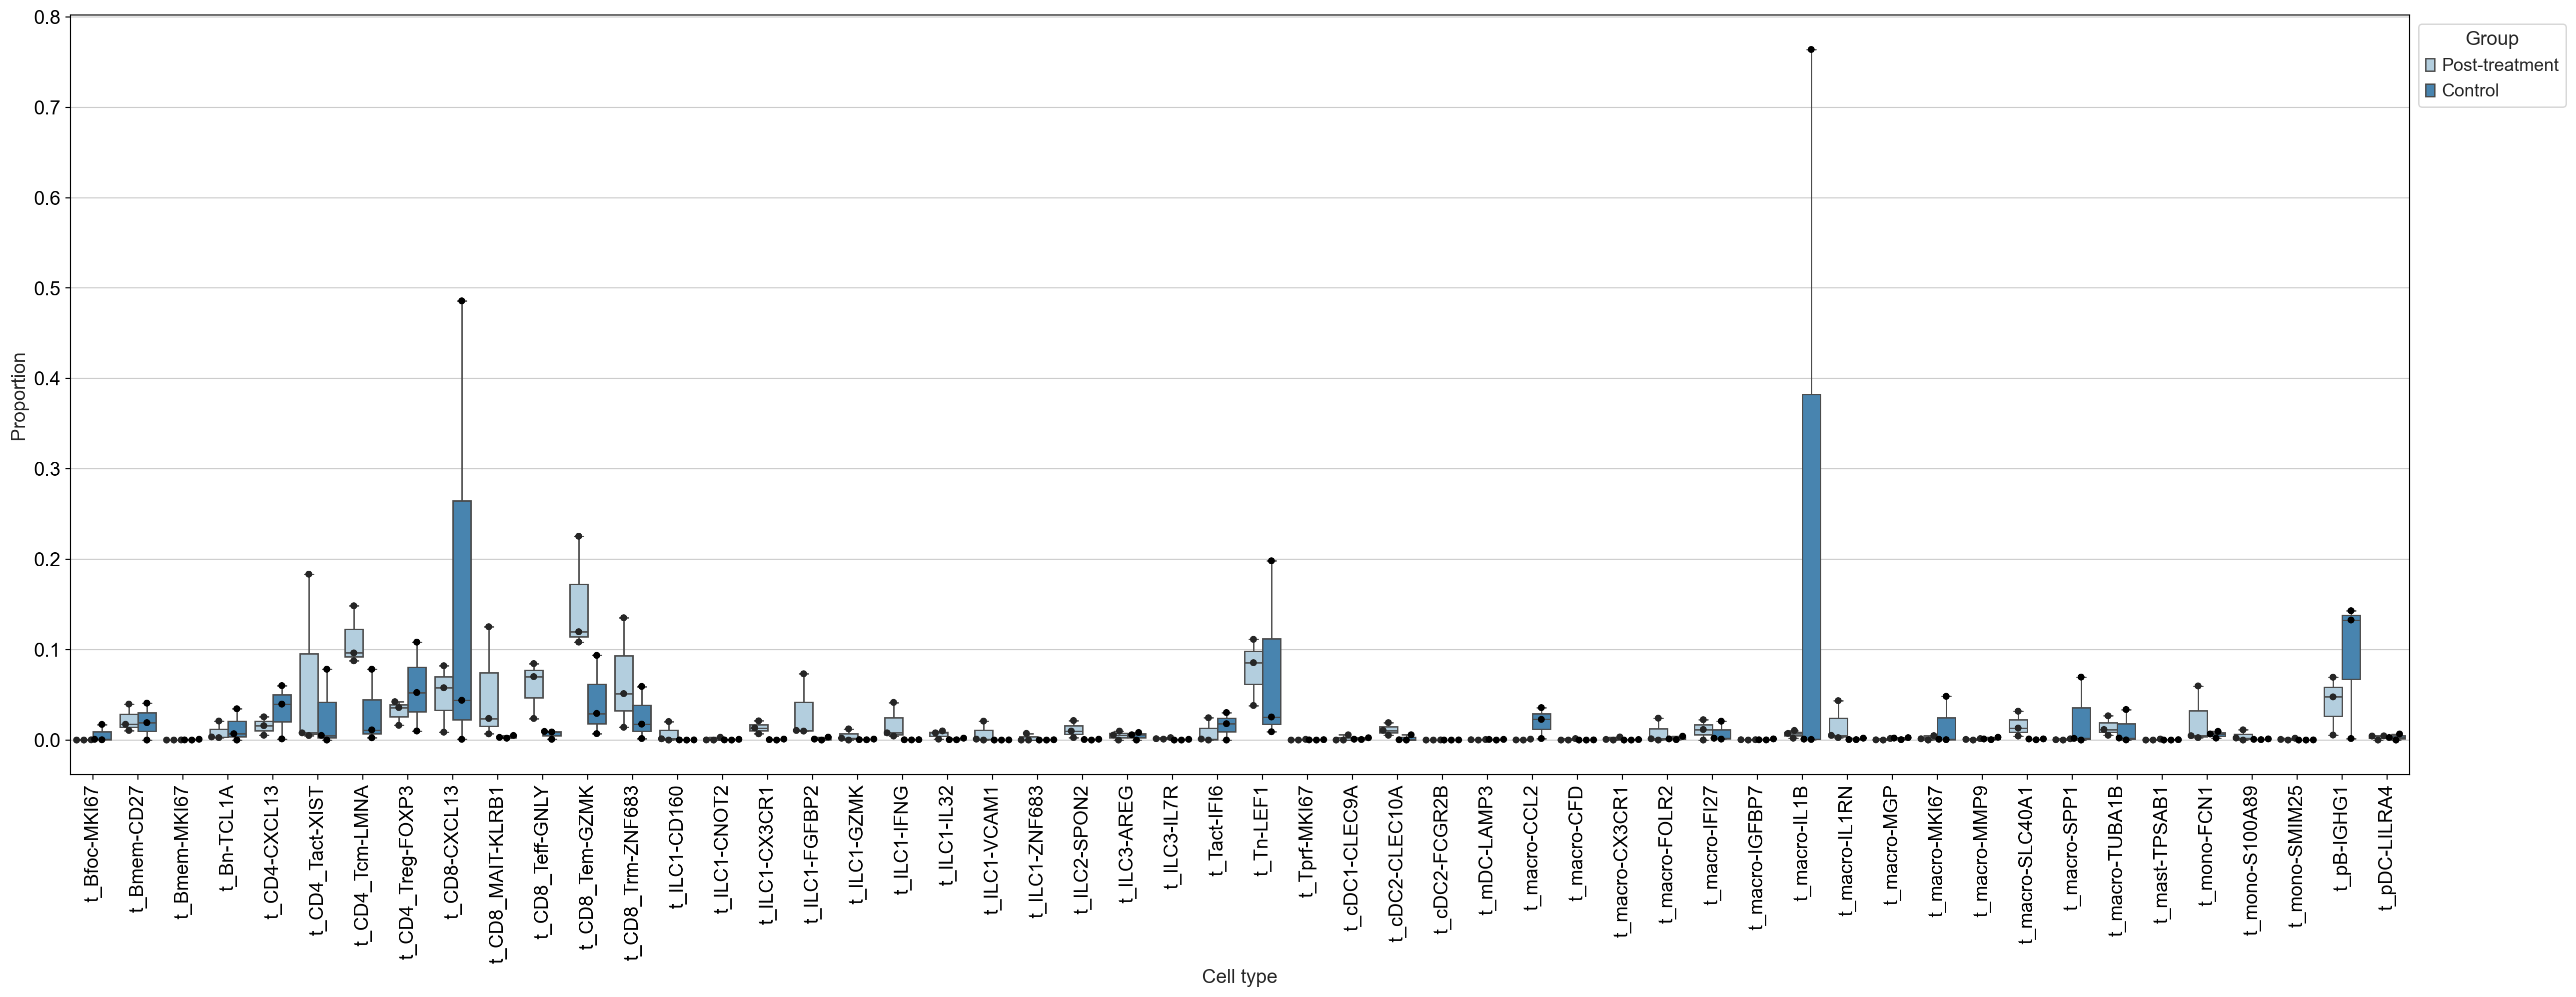

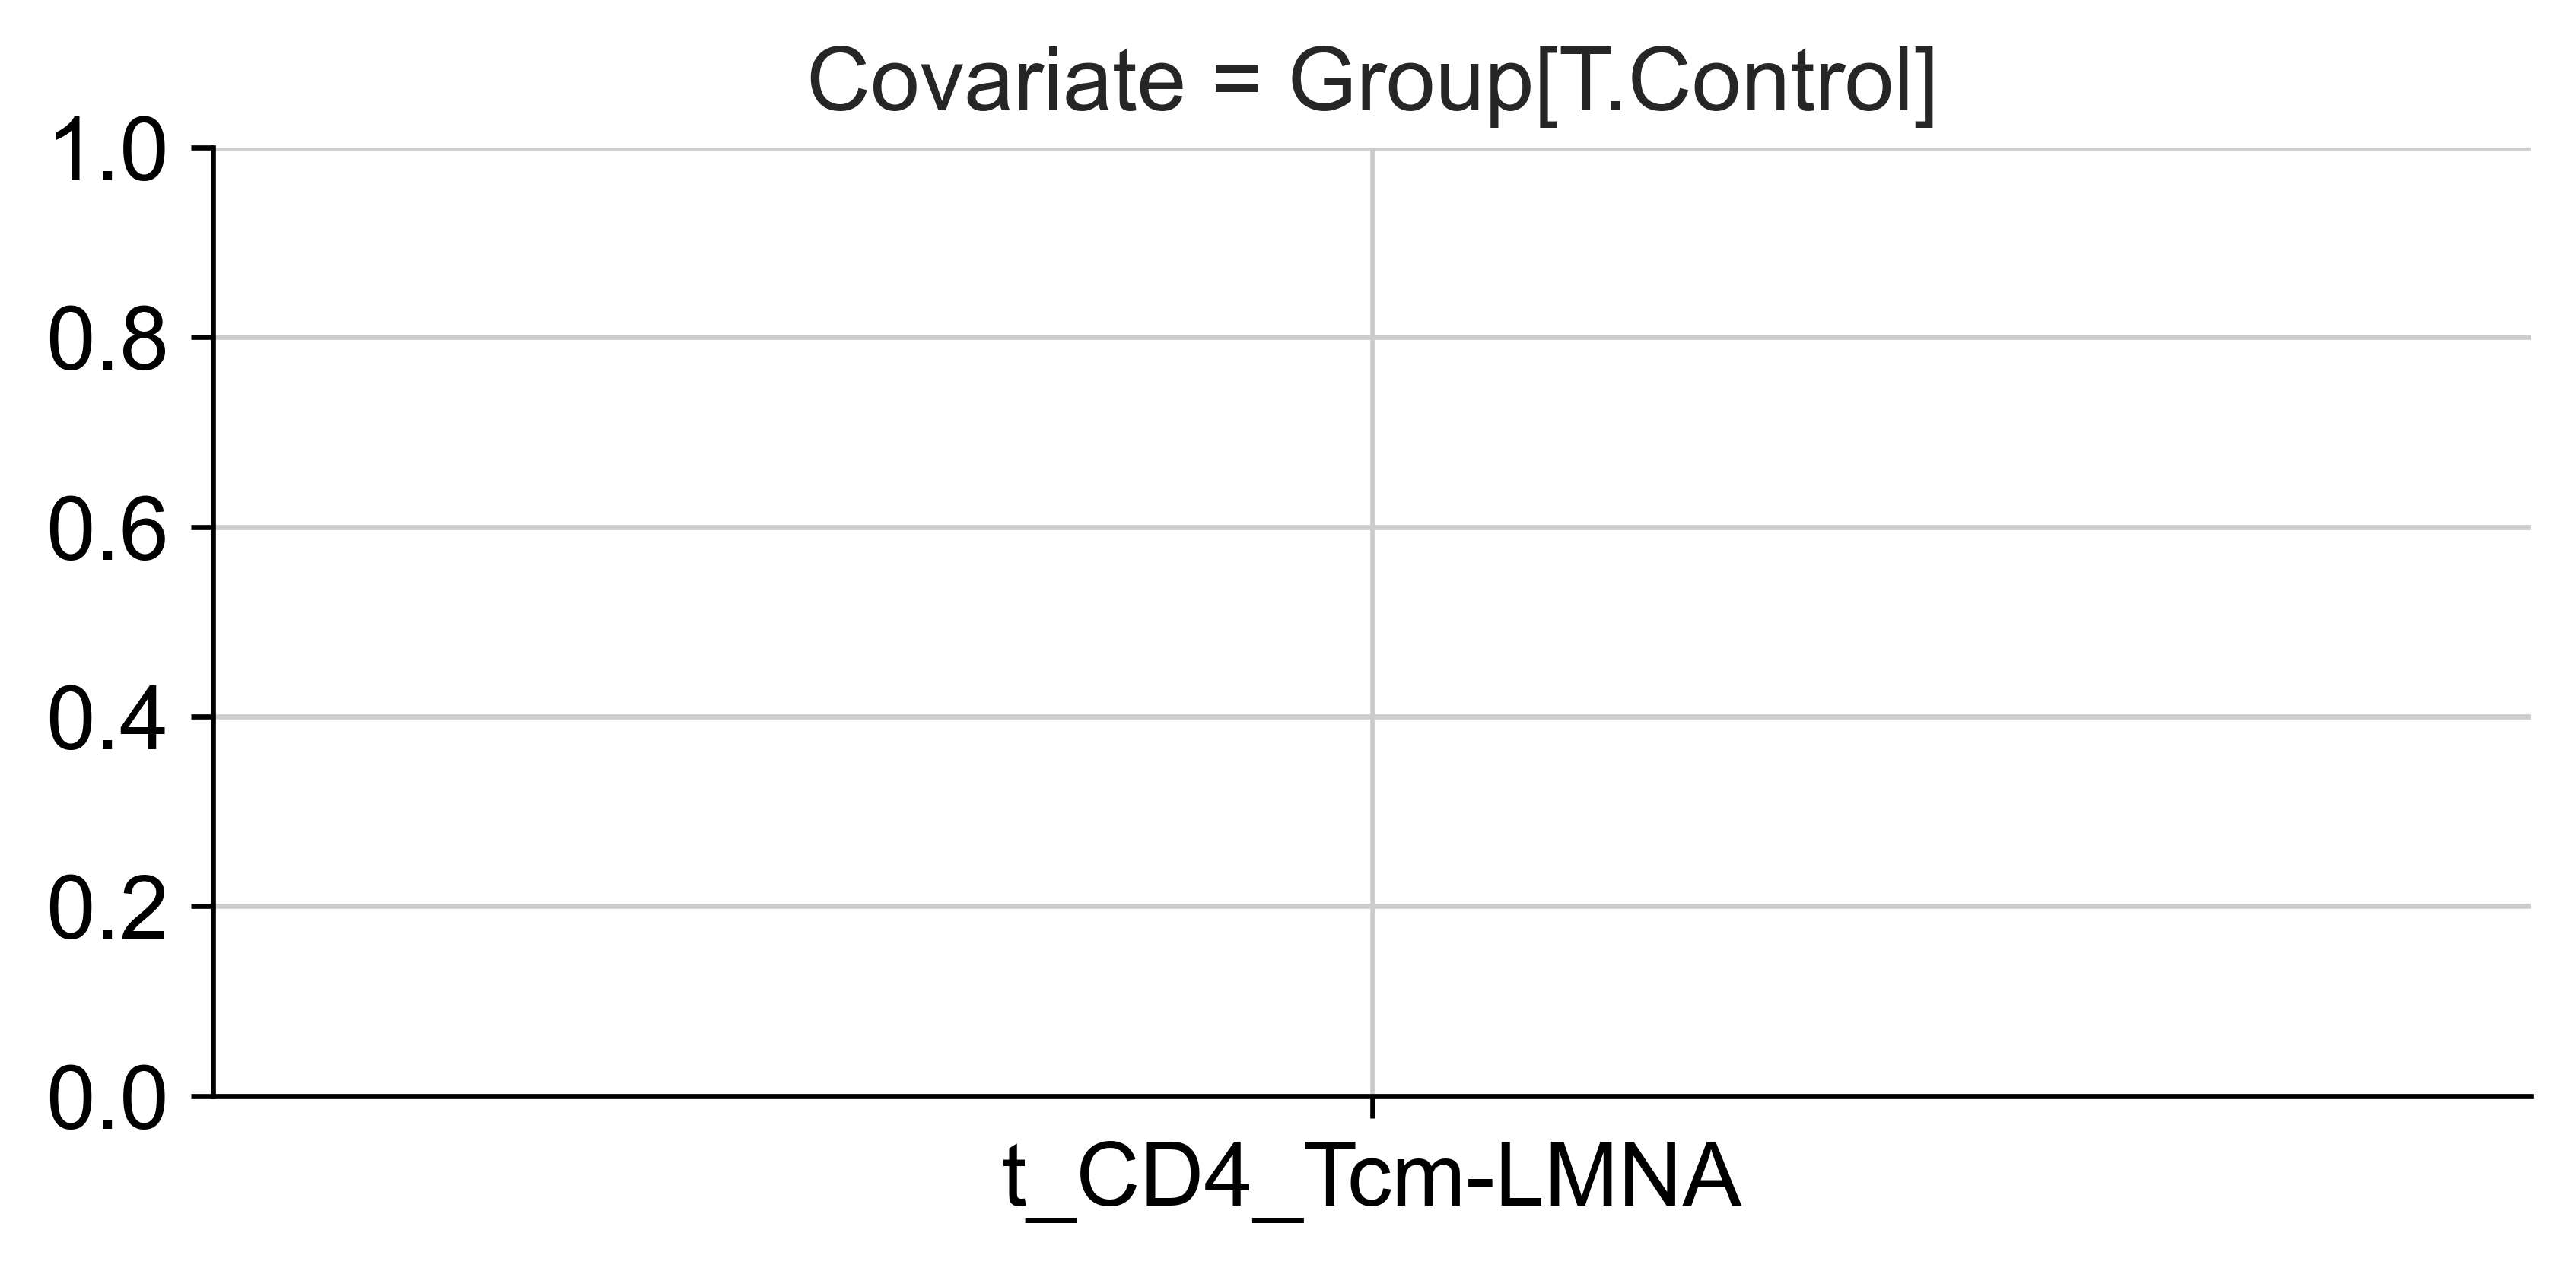

In [92]:
sccoda_pr_chemo = run_sccoda(adata_pr_chemo, "Post-treatment", plot=True)

In [72]:
effect_df = sccoda_pr_chemo["coda"].varm["effect_df_Group[T.Pre-treatment]"][["log2-fold change", "Final Parameter"]]
effect_df["Cell Type"] = effect_df.index
effect_df["Group"] = "Partial response, Chemo"
plot_df = pd.concat([plot_df, effect_df])
effect_df

,log2-fold change,Final Parameter,Cell Type,Group
Cell Type,,,,
t_Bfoc-MKI67,0.0,0.0,t_Bfoc-MKI67,"Partial response, Chemo"
t_Bmem-CD27,0.0,0.0,t_Bmem-CD27,"Partial response, Chemo"
t_Bmem-MKI67,0.0,0.0,t_Bmem-MKI67,"Partial response, Chemo"
t_Bn-TCL1A,0.0,0.0,t_Bn-TCL1A,"Partial response, Chemo"
t_CD4-CXCL13,0.0,0.0,t_CD4-CXCL13,"Partial response, Chemo"
t_CD4_Tact-XIST,0.0,0.0,t_CD4_Tact-XIST,"Partial response, Chemo"
t_CD4_Tcm-LMNA,0.0,0.0,t_CD4_Tcm-LMNA,"Partial response, Chemo"
t_CD4_Treg-FOXP3,0.0,0.0,t_CD4_Treg-FOXP3,"Partial response, Chemo"
t_CD8-CXCL13,0.0,0.0,t_CD8-CXCL13,"Partial response, Chemo"


💡 Automatic reference selection! Reference cell type set to t_pB-IGHG1
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:24<00:00, 452.46it/s, 63 steps of size 9.06e-02. acc. prob=0.53]


❗ Acceptance rate unusually low (0.5317180994857998 < 0.5)! Results might be incorrect! Please check feasibility of results and re-run the sampling step with a different rng_key if necessary.


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 6 samples, 43 cell types                                    │
│ Reference cell type                         │ t_pB-IGHG1                                                        │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                   Final Parameter  Expected Sample                                                              │
│ Cell Type                                                                                                       │
│ t_Bfoc-MKI67           0.003           246.836                                                                  │
│ t_Bfoc-NEIL1          -0.360           171.696                                                                  │
│ t_Bmem-CD27            1.598          1216.489                                                                  │
│ t_Bmem-MKI67          -1.312            66.269                                                                  │
│ t_Bn-TCL1A             1.093           734.158                                                                  │
│ t_CD4-CXCL13           0.733           512.205                                                                  │
│ t_CD4_Tact-XIST       -0.309           180.679                                                                  │
│ t_CD4_Tcm-LMNA         0.423           375.675                                                                  │
│ t_CD4_Treg-FOXP3       0.475           395.727                                                                  │
│ t_CD8-CXCL13           0.871           587.998                                                                  │
│ t_CD8_MAIT-KLRB1      -0.716           120.268                                                                  │
│ t_CD8_Teff-GNLY       -0.607           134.119                                                                  │
│ t_CD8_Tem-GZMK         0.897           603.487                                                                  │
│ t_CD8_Trm-ZNF683       0.005           247.330                                                                  │
│ t_ILC1-CD160          -1.638            47.833                                                                  │
│ t_ILC1-CNOT2          -1.678            45.958                                                                  │
│ t_ILC1-CX3CR1         -1.420            59.485                                                                  │
│ t_ILC1-FGFBP2         -1.042            86.810                                                                  │
│ t_ILC1-GZMK           -1.249            70.578                                                                  │
│ t_ILC1-IFNG           -1.395            60.991                                                                  │
│ t_ILC1-IL32           -0.908            99.258                                                                  │
│ t_ILC1-SELL           -1.509            54.420                                                                  │
│ t_ILC1-VCAM1          -1.631            48.169                                                                  │
│ t_ILC2-SPON2          -1.383            61.727                                                                  │
│ t_ILC3-AREG           -0.480           152.281                                                                  │
│ t_ILC3-IL7R           -1.182            75.469                                                                  │
│ t_Tact-IFI6           -0.963            93.946                                                                  │
│ t_Tn-LEF1              1.890          1629.004                                                                  │
│ t_cDC1-CLEC9A         -1.311            66.335                                                                  │
│ t_cDC2-CLEC10A        -1.038            87.158        

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                        Final Parameter  Expected Sample  log2-fold change                       │
│ Covariate            Cell Type                                                                                  │
│ GroupT.Pre-treatment t_Bfoc-MKI67          0.000            246.836           0.000                             │
│                      t_Bfoc-NEIL1          0.000            171.696           0.000                             │
│                      t_Bmem-CD27           0.000           1216.489           0.000                             │
│                      t_Bmem-MKI67          0.000             66.269           0.000                             │
│                      t_Bn-TCL1A            0.000            734.158           0.000                             │
│                      t_CD4-CXCL13          0.000            512.205           0.000                             │
│                      t_CD4_Tact-XIST       0.000            180.679           0.000                             │
│                      t_CD4_Tcm-LMNA        0.000            375.675           0.000                             │
│                      t_CD4_Treg-FOXP3      0.000            395.727           0.000                             │
│                      t_CD8-CXCL13          0.000            587.998           0.000                             │
│                      t_CD8_MAIT-KLRB1      0.000            120.268           0.000                             │
│                      t_CD8_Teff-GNLY       0.000            134.119           0.000                             │
│                      t_CD8_Tem-GZMK        0.000            603.487           0.000                             │
│                      t_CD8_Trm-ZNF683      0.000            247.330           0.000                             │
│                      t_ILC1-CD160          0.000             47.833           0.000                             │
│                      t_ILC1-CNOT2          0.000             45.958           0.000                             │
│                      t_ILC1-CX3CR1         0.000             59.485           0.000                             │
│                      t_ILC1-FGFBP2         0.000             86.810           0.000                             │
│                      t_ILC1-GZMK           0.000             70.578           0.000                             │
│                      t_ILC1-IFNG           0.000             60.991           0.000                             │
│                      t_ILC1-IL32           0.000             99.258           0.000                             │
│                      t_ILC1-SELL           0.000             54.420           0.000                             │
│                      t_ILC1-VCAM1          0.000             48.169           0.000                             │
│                      t_ILC2-SPON2          0.000             61.727           0.000                             │
│                      t_ILC3-AREG           0.000            152.281           0.000                             │
│                      t_ILC3-IL7R           0.000             75.469           0.000                             │
│                      t_Tact-IFI6           0.000             93.946           0.000                             │
│                      t_Tn-LEF1             0.000           1629.004           0.000                             │
│                      t_cDC1-CLEC9A         0.000             66.335           0.000                             │
│                      t_cDC2-CLEC10A        0.000      

No effects found for Post-treatment


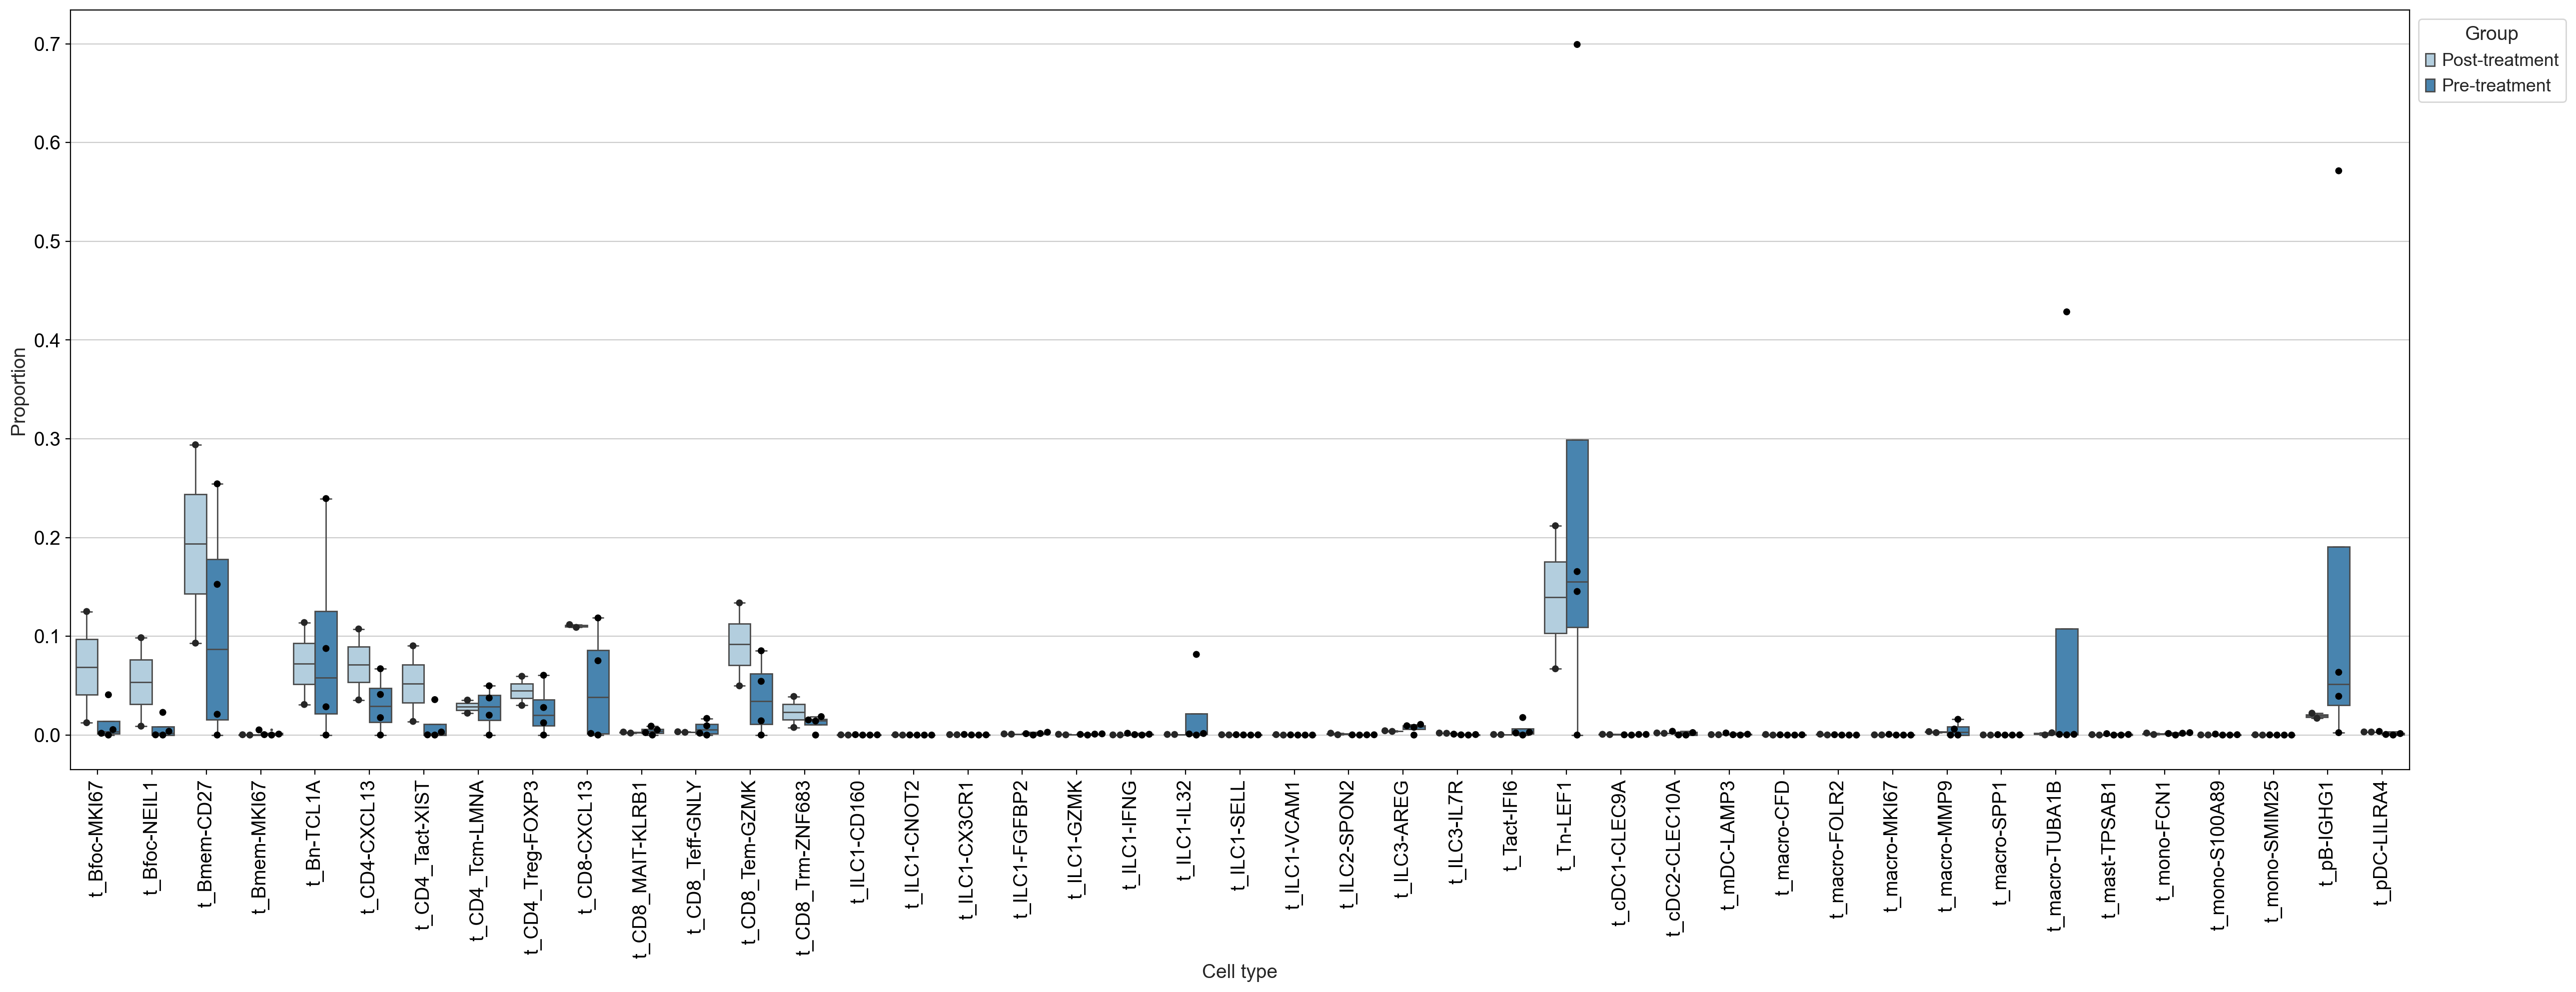

<Figure size 0x900 with 0 Axes>

In [93]:
sccoda_pr_pdl1_chemo = run_sccoda(adata_pr_pdl1_chemo, "Post-treatment", plot=True)

💡 Automatic reference selection! Reference cell type set to t_mDC-LAMP3
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:29<00:00, 369.36it/s, 63 steps of size 9.04e-02. acc. prob=0.62]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 6 samples, 54 cell types                                    │
│ Reference cell type                         │ t_mDC-LAMP3                                                       │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                   Final Parameter  Expected Sample                                                              │
│ Cell Type                                                                                                       │
│ t_Bfoc-MKI67          -1.122           34.259                                                                   │
│ t_Bfoc-NEIL1          -1.248           30.203                                                                   │
│ t_Bmem-CD27            0.921          264.262                                                                   │
│ t_Bmem-MKI67          -1.301           28.644                                                                   │
│ t_Bn-TCL1A            -0.535           61.617                                                                   │
│ t_CD4-CXCL13           0.891          256.451                                                                   │
│ t_CD4_Tact-XIST        0.603          192.277                                                                   │
│ t_CD4_Tcm-LMNA         1.477          460.789                                                                   │
│ t_CD4_Treg-FOXP3       1.273          375.756                                                                   │
│ t_CD8-CXCL13           0.655          202.540                                                                   │
│ t_CD8_MAIT-KLRB1      -0.462           66.283                                                                   │
│ t_CD8_Teff-GNLY        0.034          108.847                                                                   │
│ t_CD8_Tem-GZMK         2.061          826.285                                                                   │
│ t_CD8_Trm-ZNF683       1.230          359.941                                                                   │
│ t_ILC1-CD160          -1.406           25.789                                                                   │
│ t_ILC1-CNOT2          -1.467           24.263                                                                   │
│ t_ILC1-CX3CR1         -1.249           30.173                                                                   │
│ t_ILC1-FGFBP2         -0.812           46.709                                                                   │
│ t_ILC1-GZMK           -1.089           35.408                                                                   │
│ t_ILC1-IFNG           -1.274           29.428                                                                   │
│ t_ILC1-IL32           -1.077           35.836                                                                   │
│ t_ILC1-SELL           -1.521           22.987                                                                   │
│ t_ILC1-VCAM1          -1.469           24.214                                                                   │
│ t_ILC1-ZNF683         -1.524           22.918                                                                   │
│ t_ILC2-SPON2          -1.212           31.310                                                                   │
│ t_ILC3-AREG           -0.090           96.153                                                                   │
│ t_ILC3-IL7R           -1.279           29.281                                                                   │
│ t_Tact-IFI6           -0.138           91.647                                                                   │
│ t_Tn-LEF1              1.649          547.268                                                                   │
│ t_Tprf-MKI67          -1.605           21.135         

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                        Final Parameter  Expected Sample  log2-fold change                       │
│ Covariate            Cell Type                                                                                  │
│ GroupT.Pre-treatment t_Bfoc-MKI67          0.000            34.259            0.000                             │
│                      t_Bfoc-NEIL1          0.000            30.203            0.000                             │
│                      t_Bmem-CD27           0.000           264.262            0.000                             │
│                      t_Bmem-MKI67          0.000            28.644            0.000                             │
│                      t_Bn-TCL1A            0.000            61.617            0.000                             │
│                      t_CD4-CXCL13          0.000           256.451            0.000                             │
│                      t_CD4_Tact-XIST       0.000           192.277            0.000                             │
│                      t_CD4_Tcm-LMNA        0.000           460.789            0.000                             │
│                      t_CD4_Treg-FOXP3      0.000           375.756            0.000                             │
│                      t_CD8-CXCL13          0.000           202.540            0.000                             │
│                      t_CD8_MAIT-KLRB1      0.000            66.283            0.000                             │
│                      t_CD8_Teff-GNLY       0.000           108.847            0.000                             │
│                      t_CD8_Tem-GZMK        0.000           826.285            0.000                             │
│                      t_CD8_Trm-ZNF683      0.000           359.941            0.000                             │
│                      t_ILC1-CD160          0.000            25.789            0.000                             │
│                      t_ILC1-CNOT2          0.000            24.263            0.000                             │
│                      t_ILC1-CX3CR1         0.000            30.173            0.000                             │
│                      t_ILC1-FGFBP2         0.000            46.709            0.000                             │
│                      t_ILC1-GZMK           0.000            35.408            0.000                             │
│                      t_ILC1-IFNG           0.000            29.428            0.000                             │
│                      t_ILC1-IL32           0.000            35.836            0.000                             │
│                      t_ILC1-SELL           0.000            22.987            0.000                             │
│                      t_ILC1-VCAM1          0.000            24.214            0.000                             │
│                      t_ILC1-ZNF683         0.000            22.918            0.000                             │
│                      t_ILC2-SPON2          0.000            31.310            0.000                             │
│                      t_ILC3-AREG           0.000            96.153            0.000                             │
│                      t_ILC3-IL7R           0.000            29.281            0.000                             │
│                      t_Tact-IFI6           0.000            91.647            0.000                             │
│                      t_Tn-LEF1             0.000           547.268            0.000                             │
│                      t_Tprf-MKI67          0.000      

No effects found for Post-treatment


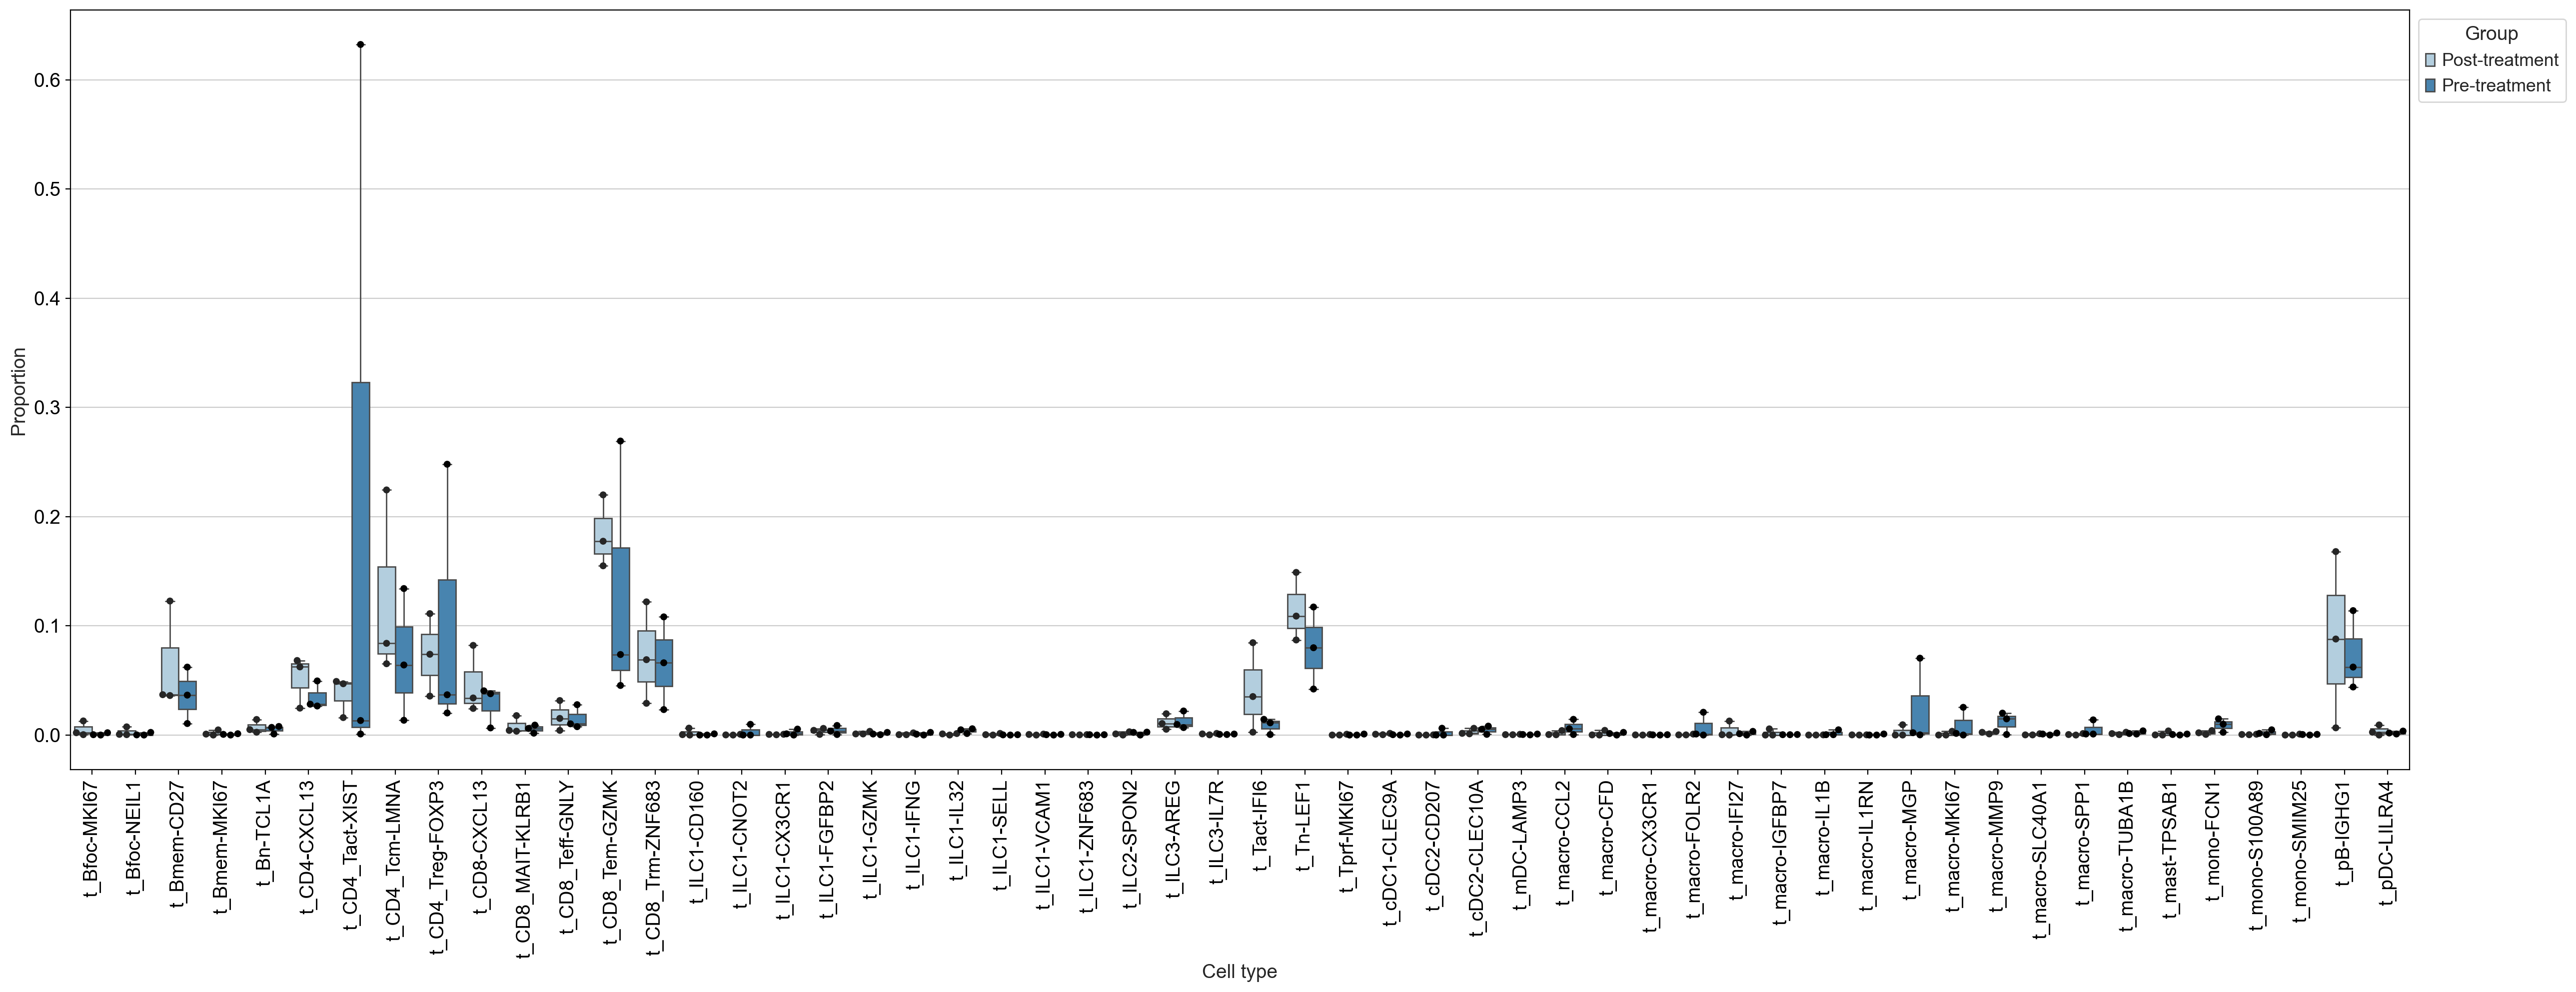

<Figure size 0x900 with 0 Axes>

In [94]:
sccoda_sd_chemo = run_sccoda(adata_sd_chemo, "Post-treatment", plot=True)

ValueError: No cell types that have large enough presence! Please increase automatic_reference_absence_threshold

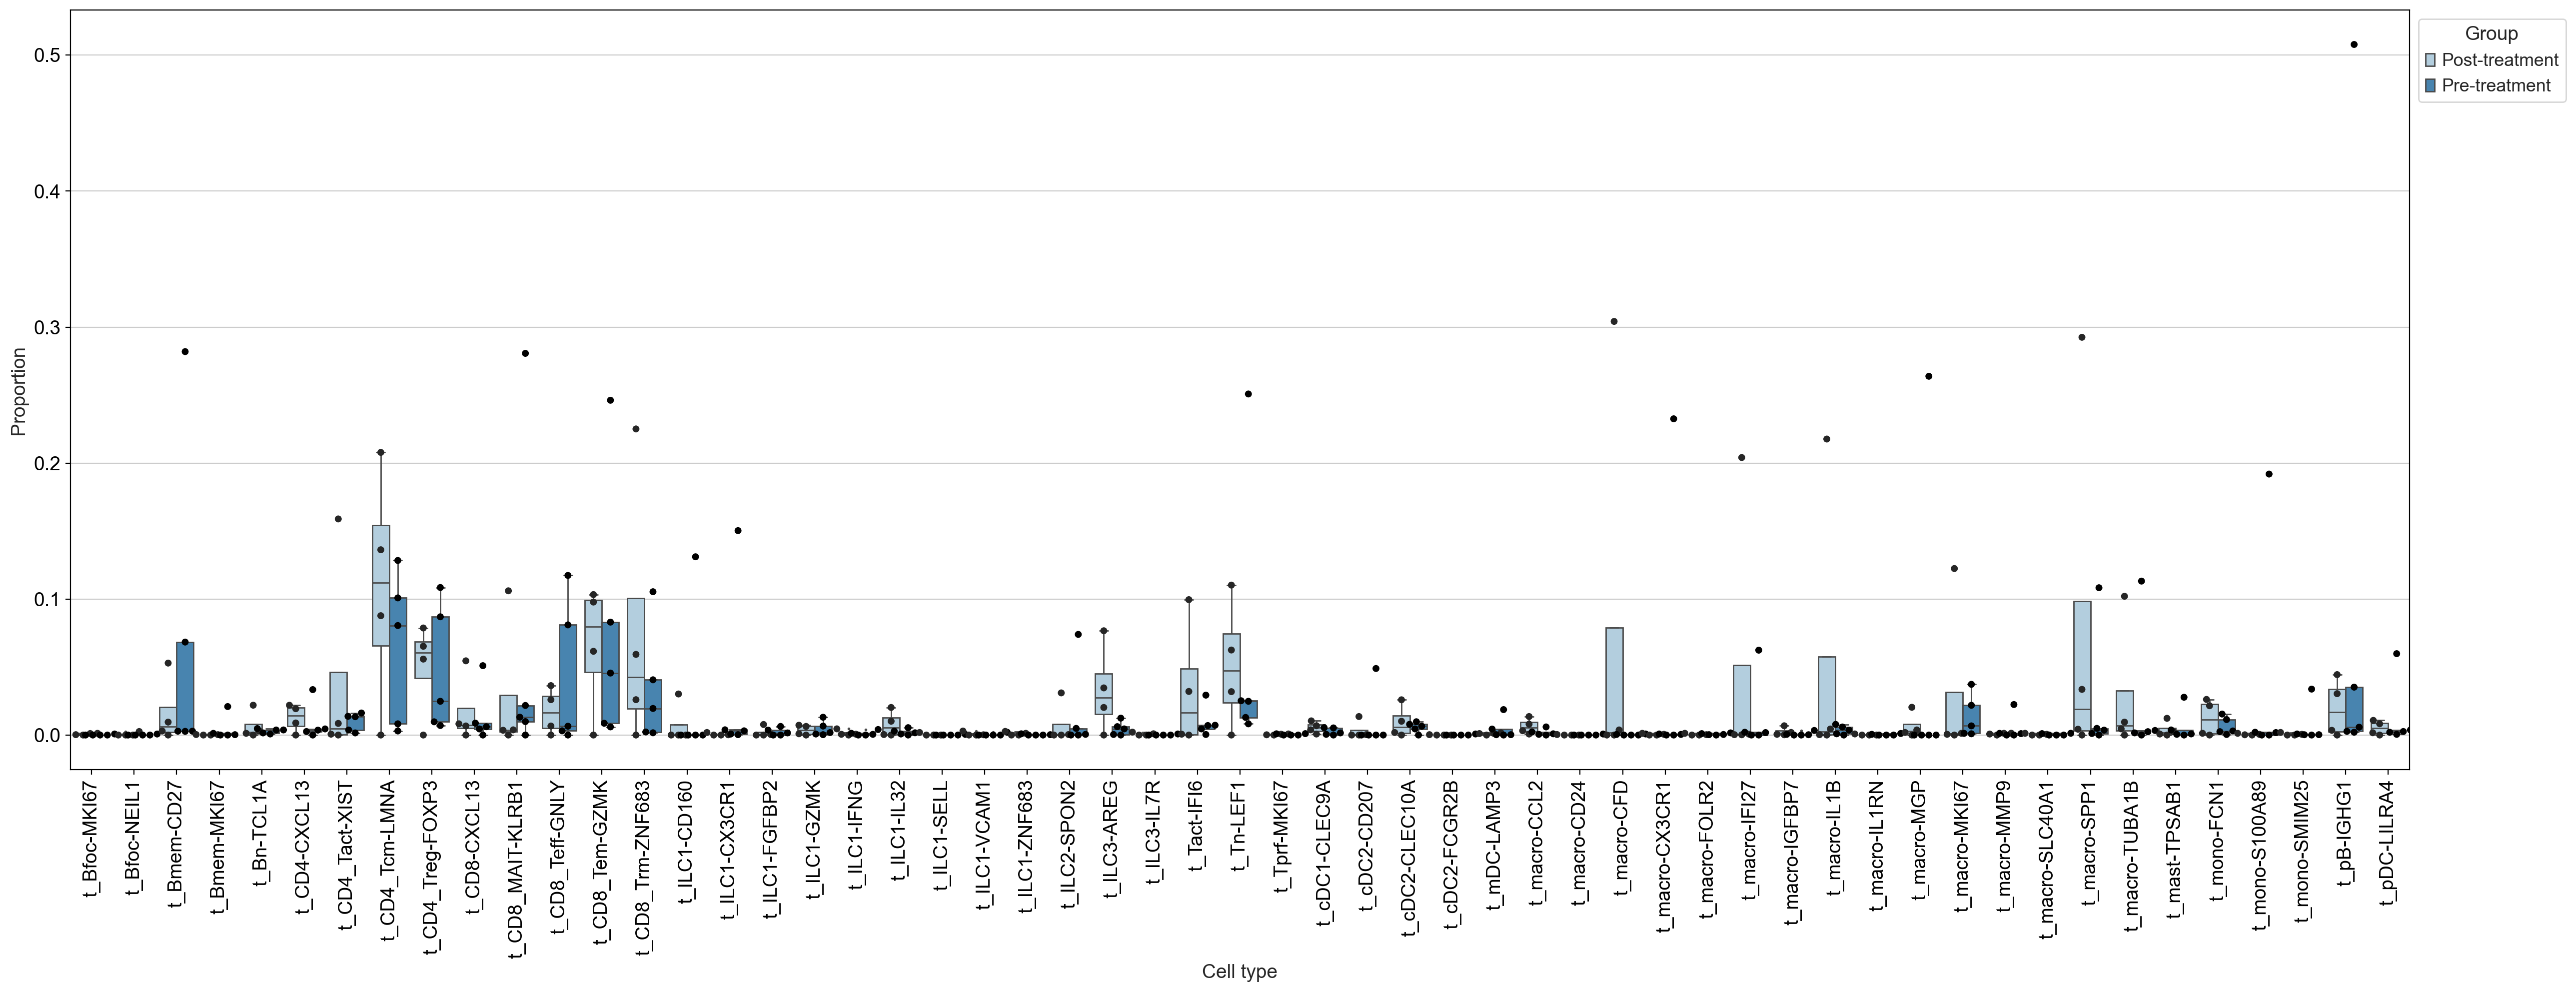

In [95]:
sccoda_sd_pd1_chemo = run_sccoda(adata_sd_pdl1_chemo, "Post-treatment", plot=True)